## 1. Project Objectives
< >

## 2. Data Collection
In this project, the Chinook database serves as our data source. The link to the database is provided below.

https://github.com/lerocha/chinook-database

In [2]:
#Loading SQL extension. Use sqlalchemy-1.4.49
%load_ext sql

#Connecting to SQLite database
%sql sqlite:///../data/raw/Chinook_Sqlite.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: @../data/raw/Chinook_Sqlite.sqlite'

## 3. Data Exploration and Cleaning

### a) ER diagram

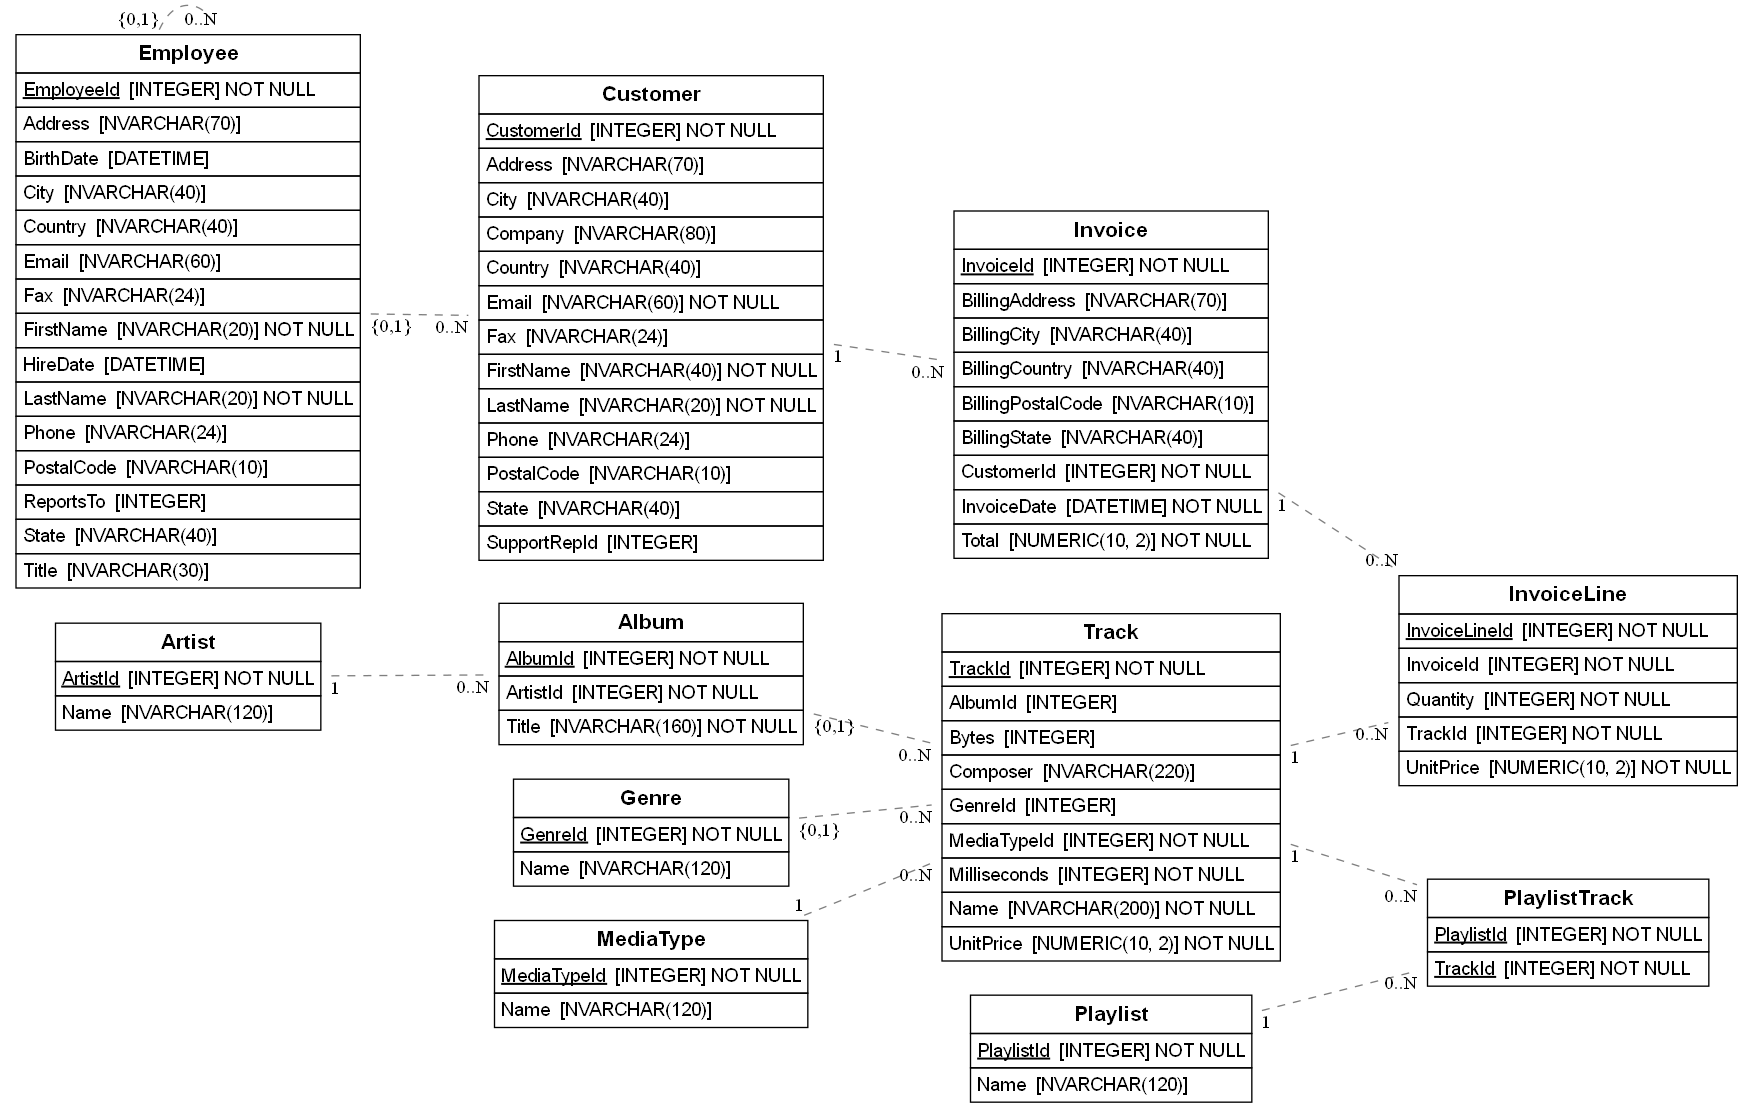

In [4]:
from eralchemy2 import render_er
from IPython.display import Image

database_url = "sqlite:///../data/raw/Chinook_Sqlite.sqlite"
output_file = "chinook_er_diagram.png"
render_er(database_url, output_file)
Image(filename=output_file)

### b) Simple queries to understand and clean data
The Chinook database contains clean and well-organized data in general. The following queries show the first few rows of each table, helping identify any obvious issues or inconsistencies that could affect the analysis.

In [5]:
# Table names: Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

%sql SELECT * FROM Customer LIMIT 5;

 * sqlite:///../data/raw/Chinook_Sqlite.sqlite
Done.


[(1, 'Luís', 'Gonçalves', 'Embraer - Empresa Brasileira de Aeronáutica S.A.', 'Av. Brigadeiro Faria Lima, 2170', 'São José dos Campos', 'SP', 'Brazil', '12227-000', '+55 (12) 3923-5555', '+55 (12) 3923-5566', 'luisg@embraer.com.br', 3),
 (2, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'leonekohler@surfeu.de', 5),
 (3, 'François', 'Tremblay', None, '1498 rue Bélanger', 'Montréal', 'QC', 'Canada', 'H2G 1A7', '+1 (514) 721-4711', None, 'ftremblay@gmail.com', 3),
 (4, 'Bjørn', 'Hansen', None, 'Ullevålsveien 14', 'Oslo', None, 'Norway', '0171', '+47 22 44 22 22', None, 'bjorn.hansen@yahoo.no', 4),
 (5, 'František', 'Wichterlová', 'JetBrains s.r.o.', 'Klanova 9/506', 'Prague', None, 'Czech Republic', '14700', '+420 2 4172 5555', '+420 2 4172 5555', 'frantisekw@jetbrains.com', 4)]

In [6]:
%%sql 
SELECT COUNT(*) AS NullCount 
FROM Customer 
WHERE TRIM(Country) IS NULL OR TRIM(Country) = '';

 * sqlite:///../data/raw/Chinook_Sqlite.sqlite
Done.


[(0,)]

**List and explain all issues and how you fixed them.**

## 4. Feature Engineering

Deriving features from the Chinook database involves creating new metrics that can help provide deeper insights into the customer behavior, product popularity, market analysis, and sales performance. 

### a) Customer-Level Features
The customer-level aggregate features derived from the database can be used for advanced analyses, such as customer segmentation, personalization strategies, and predictive modeling. Here, we list key features:
- **Total Spend Per Customer**: This feature represents the total amount spent by each customer over all their transactions.
- **Number of Orders**: The total number of orders placed by a customer.
- **Average Purchase Value**: Calculates the average amount spent per invoice by each customer.
- **Customer Lifetime**: The duration between a customer's first and last purchase (customer loyalty).
- **Purchase Recency and Frequency**: How recently and how often a customer makes purchases (customer engagement).
- **Genre Loyalty**: Customer's preference for specific genres
- **Favourite Artist**: The artist a customer has purchased the most tracks from
- **Product Diversity**: Number of unique tracks or albums purchased by a customer.
- **Monthly Purchase**: The month in which a customer is most active.
- **Spending Tiers**: Categorizes customers based on their total spending into different tiers.


In [119]:
%%sql
SELECT
    CustomerId,
    TotalSpend,
    NumberOfOrders,
    AvgPurchaseValue,
    CustomerLifetimeYears,
    LastPurchaseDate,
    CASE 
        WHEN CustomerLifetimeYears>0
        THEN ROUND(NumberOfOrders/CustomerLifetimeYears,2)
        ELSE 0
    END AS PurchaseFrequency
FROM(    
    SELECT
        CustomerId,
        SUM(Total) AS TotalSpend,
        COUNT(InvoiceId) AS NumberOfOrders,
        ROUND(AVG(Total),2) AS AvgPurchaseValue,
        ROUND((JULIANDAY(MAX(InvoiceDate)) - JULIANDAY(MIN(InvoiceDate)))/365,2) AS CustomerLifetimeYears,
        DATE(MAX(InvoiceDate)) AS LastPurchaseDate
    FROM
        Invoice
    GROUP BY CustomerId
    )
GROUP BY CustomerId
ORDER BY CustomerId
LIMIT 5;

 * sqlite:///../data/raw/Chinook_Sqlite.sqlite
Done.


[(1, 39.62, 7, 5.66, 3.41, '2013-08-07', 2.05),
 (2, 37.62, 7, 5.37, 3.53, '2012-07-13', 1.98),
 (3, 39.62, 7, 5.66, 3.53, '2013-09-20', 1.98),
 (4, 39.62, 7, 5.66, 4.75, '2013-10-03', 1.47),
 (5, 40.62, 7, 5.8, 3.41, '2013-05-06', 2.05)]

In [120]:
%%sql
WITH GenreQuantities AS (
    SELECT
        Inv.CustomerId,
        Tr.GenreId,
        SUM(InvL.Quantity) AS TotalQuantity
    FROM
        InvoiceLine InvL 
        JOIN Invoice Inv ON Inv.InvoiceId = InvL.InvoiceId
        JOIN Track Tr ON Tr.TrackId = InvL.TrackId
    GROUP BY CustomerId, GenreId
),

MaxQuantities AS (
    SELECT 
        CustomerId, 
        MAX(TotalQuantity) AS MaxQuantity
    FROM 
        GenreQuantities
    GROUP BY CustomerId
)

SELECT 
    g.CustomerId, 
    g.GenreId AS PreferredGenreId, 
    g.TotalQuantity
FROM 
    GenreQuantities g
    JOIN MaxQuantities m ON g.CustomerId = m.CustomerId AND g.TotalQuantity = m.MaxQuantity
LIMIT 5;

 * sqlite:///../data/raw/Chinook_Sqlite.sqlite
Done.


[(1, 1, 14), (2, 1, 17), (3, 3, 10), (4, 1, 17), (5, 1, 15)]

In [12]:
%sql SELECT * FROM Invoice LIMIT 5;

 * sqlite:///../data/raw/Chinook_Sqlite.sqlite
Done.


[(1, 2, '2009-01-01 00:00:00', 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', 1.98),
 (2, 4, '2009-01-02 00:00:00', 'Ullevålsveien 14', 'Oslo', None, 'Norway', '0171', 3.96),
 (3, 8, '2009-01-03 00:00:00', 'Grétrystraat 63', 'Brussels', None, 'Belgium', '1000', 5.94),
 (4, 14, '2009-01-06 00:00:00', '8210 111 ST NW', 'Edmonton', 'AB', 'Canada', 'T6G 2C7', 8.91),
 (5, 23, '2009-01-11 00:00:00', '69 Salem Street', 'Boston', 'MA', 'USA', '2113', 13.86)]